## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

In [2]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')
surrogate_domain_num = 50
for i in range(surrogate_domain_num):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_convex_concave.csv')")
df_t_labeled = df_t.sample(8).reset_index(drop=True)

In [4]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(surrogate_domain_num):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
exec(f"x_t{surrogate_domain_num} = copy.deepcopy(x_s)")
exec(f"y_t{surrogate_domain_num} = copy.deepcopy(y_s)")

## MAML

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 10)
        self.relu = nn.ELU()
        self.h2 = nn.Linear(10, 10)
        self.h3 = nn.Linear(10, 10)
        self.reg = nn.Linear(10, 1)
        # self.drop1 = nn.Dropout()
        # self.drop2 = nn.Dropout()
        
    def forward(self, x):
        x = self.h1(x)
        x = self.relu(x)
        x = self.h2(x)
        x = self.relu(x)
        x = self.h3(x)
        x = self.relu(x)
        x = self.reg(x)

        return x

### Meta-Learning

In [13]:
parent_model = MLP()
optimizer = optim.Adam(parent_model.parameters(), lr=0.1)
domain_num = 4 + 1
batch_domain = 5
batch_num = 8
best_loss = 100000
best_parent_model = None


# initialize
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(parent_model(x_s), y_s)
    train_loss.backward()
    optimizer.step()
mlp_model = copy.deepcopy(parent_model)


# parent_model = MLP()
# optimizer = optim.Adam(parent_model.parameters(), lr=0.1)

for outer_epoch in tqdm(range(10000)):
    parent_model.eval()
    
    batch_domain_list = random.sample(range(domain_num), batch_domain)
    
    for batch_domain_idx in batch_domain_list:
        batch_data_list = random.sample(range(len(x_t0)), len(x_t0))
        batch_train_data_list = batch_data_list[:batch_num]
        batch_val_data_list = batch_data_list[batch_num:]
        exec(f"child_model{batch_domain_idx} = copy.deepcopy(parent_model)")
        exec(f"optimizer{batch_domain_idx} = optim.Adam(child_model{batch_domain_idx}.parameters(), lr = 0.1)")
        exec(f"child_model{batch_domain_idx}.train()")
        for inner_epoch in range(100):
            exec(f"optimizer{batch_domain_idx}.zero_grad()")
            exec(f"temp_loss = torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_train_data_list]), x_s[batch_train_data_list])")
            temp_loss.backward()
            exec(f"optimizer{batch_domain_idx}.step()")
    
    parent_model.train()
    optimizer.zero_grad()
    loss = 0
    for batch_domain_idx in batch_domain_list:
        exec(f"loss += torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_val_data_list]), x_s[batch_val_data_list])")
    loss /= batch_domain
    if best_loss > loss:
        best_loss = loss
        best_parent_model = copy.deepcopy(parent_model)
        best_parent_model.eval()
        print(f"epoch : {outer_epoch}, train loss : {loss.detach().item()}")
    loss.backward()
    optimizer.step()
    

  0%|          | 1/10000 [00:00<1:57:49,  1.41it/s]

epoch : 0, train loss : 5.978281021118164


  0%|          | 4/10000 [00:02<1:59:00,  1.40it/s]

epoch : 3, train loss : 5.248806953430176


  0%|          | 6/10000 [00:04<1:57:51,  1.41it/s]

epoch : 5, train loss : 4.447364807128906


  0%|          | 24/10000 [00:17<1:59:27,  1.39it/s]

epoch : 23, train loss : 4.225291728973389


  0%|          | 38/10000 [00:26<1:43:48,  1.60it/s]

epoch : 37, train loss : 3.6800785064697266


  0%|          | 41/10000 [00:28<1:37:47,  1.70it/s]

epoch : 40, train loss : 3.570283889770508


  0%|          | 44/10000 [00:30<1:49:13,  1.52it/s]

epoch : 43, train loss : 2.739637851715088


  1%|          | 73/10000 [00:48<1:33:57,  1.76it/s]

epoch : 72, train loss : 1.5588372945785522


  2%|▏         | 173/10000 [01:50<1:45:01,  1.56it/s]


KeyboardInterrupt: 

### Meta-Inference

100%|██████████| 10/10 [00:00<00:00, 233.05it/s]

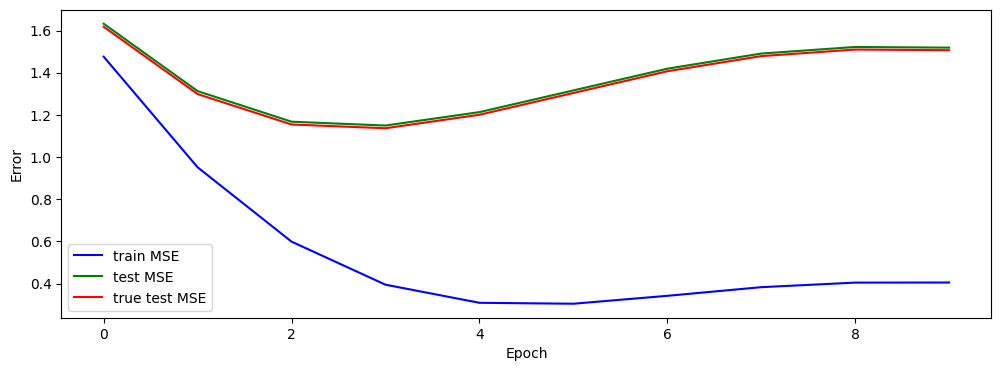

test mse : 1.5188204050064087, denoised test mse : 1.5067204236984253


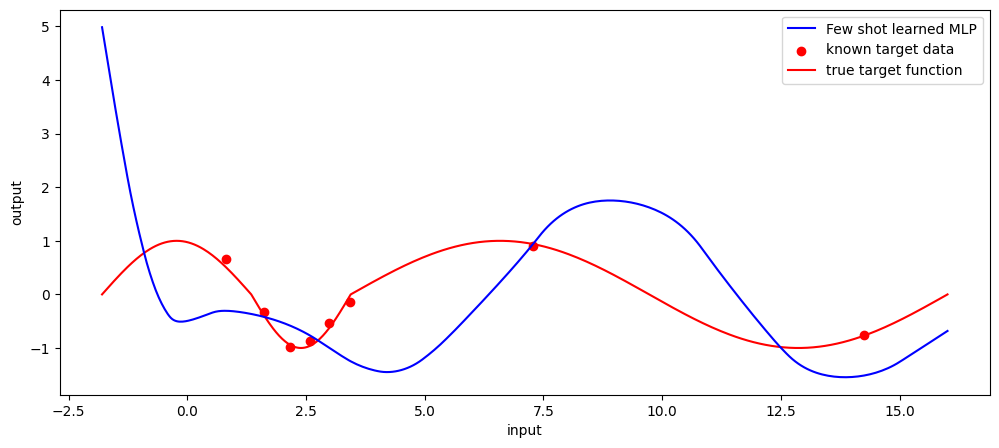

In [18]:
few_shot_learned_mlp_model = copy.deepcopy(mlp_model)
mlp_optimizer = optim.Adam(few_shot_learned_mlp_model.parameters(), lr=0.01)
train_loss_list_mlp = []
test_loss_list_mlp = []
true_test_loss_list_mlp = []
model_list_mlp = []
for i in tqdm(range(10)):
    model_list_mlp.append(copy.deepcopy(few_shot_learned_mlp_model))
    few_shot_learned_mlp_model.eval()
    test_loss_list_mlp.append(torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t).detach().item())
    true_test_loss_list_mlp.append(torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t_true).detach().item())

    few_shot_learned_mlp_model.train()
    mlp_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t_labeled), y_t_labeled)
    # train_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t)
    
    train_loss.backward()
    mlp_optimizer.step()
    train_loss_list_mlp.append(train_loss.detach().item())

plt.figure(figsize=(12,4))
plt.plot(range(len(train_loss_list_mlp)), train_loss_list_mlp, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list_mlp)), test_loss_list_mlp, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list_mlp)), true_test_loss_list_mlp, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(x_t, few_shot_learned_mlp_model(x_t).detach().numpy(), c='blue', label='Few shot learned MLP', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list_mlp[-1]}, denoised test mse : {true_test_loss_list_mlp[-1]}")

In [19]:
target_model = copy.deepcopy(best_parent_model)
target_model.train()
target_optimizer = optim.Adam(target_model.parameters(), lr=0.01)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in tqdm(range(10)):
    model_list.append(copy.deepcopy(target_model))
    target_model.eval()
    target_model(x_t)
    test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t_true).detach().item())

    target_model.train()
    target_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(target_model(x_t_labeled), y_t_labeled)
    train_loss.backward()
    target_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 247.36it/s]


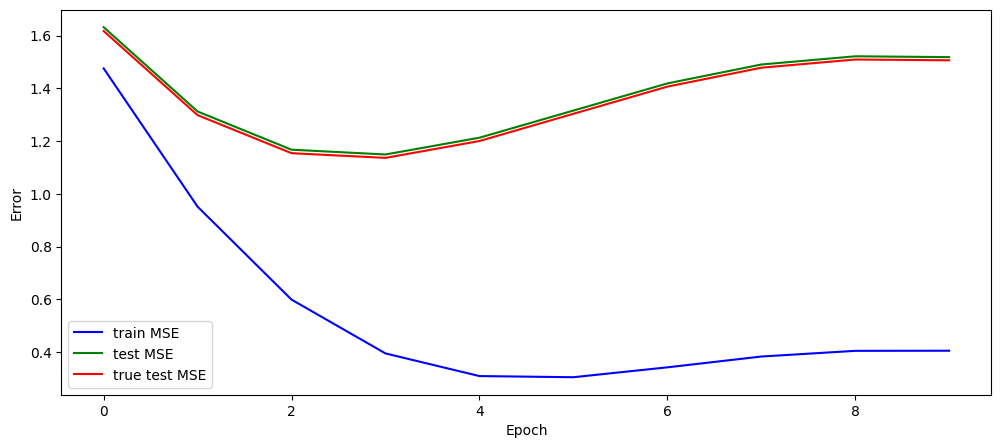

test mse : 1.5188204050064087, denoised test mse : 1.5067204236984253


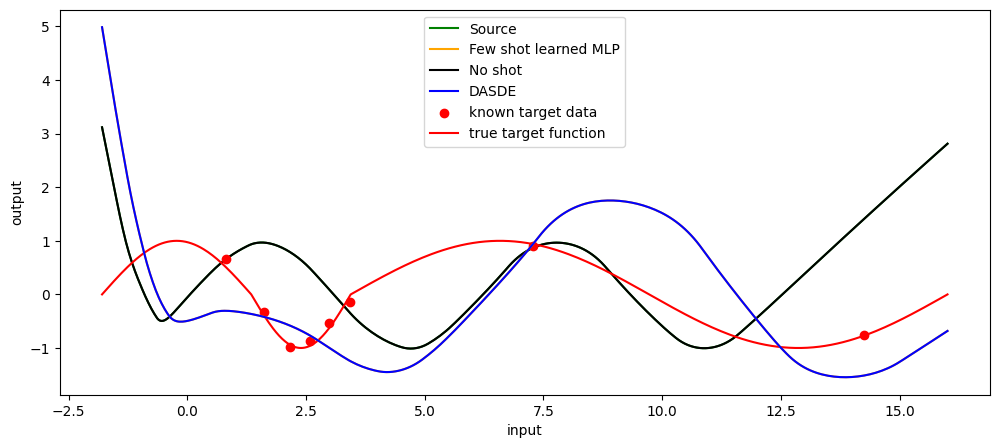

In [20]:
plt.figure(figsize=(12,5))
start_point = 0
end_point = 1000
plt.plot(range(len(train_loss_list[start_point:end_point])), train_loss_list[start_point:end_point], c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list[start_point:end_point])), test_loss_list[start_point:end_point], c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list[start_point:end_point])), true_test_loss_list[start_point:end_point], c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(x_t, mlp_model(x_t).detach().numpy(), c='green', label='Source', zorder=1)
plt.plot(x_t, few_shot_learned_mlp_model(x_t).detach().numpy(), c='orange', label='Few shot learned MLP', zorder=3)
plt.plot(x_t, best_parent_model(x_t).detach().numpy(), c='black', label='No shot', zorder=1)
plt.plot(x_t, target_model(x_t).detach().numpy(), c='blue', label='DASDE', zorder=3)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list[-1]}, denoised test mse : {true_test_loss_list[-1]}")

## Only Target MLP

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 272.86it/s]


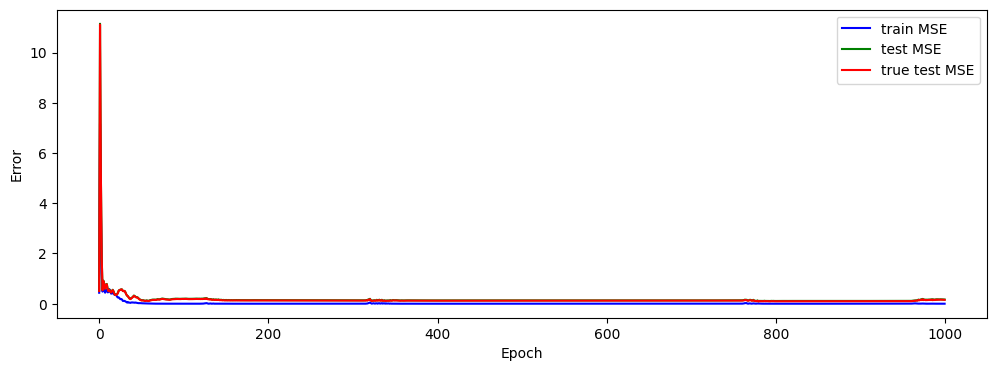

test mse : 0.16613084077835083, denoised test mse : 0.15312506258487701


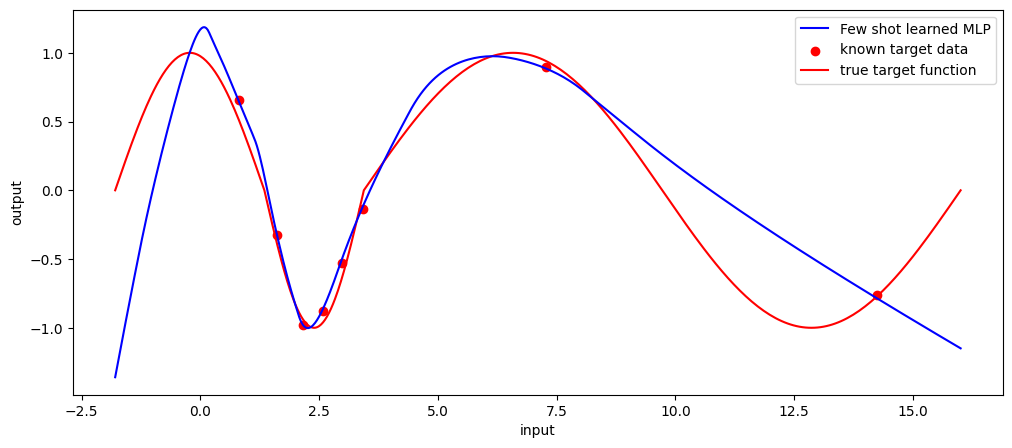

In [12]:
only_target_mlp_model = MLP()
mlp_optimizer = optim.Adam(only_target_mlp_model.parameters(), lr=0.1)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in tqdm(range(1000)):
    model_list.append(copy.deepcopy(only_target_mlp_model))
    only_target_mlp_model.eval()
    test_loss_list.append(torch.nn.functional.mse_loss(only_target_mlp_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(only_target_mlp_model(x_t), y_t_true).detach().item())

    only_target_mlp_model.train()
    mlp_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(only_target_mlp_model(x_t_labeled), y_t_labeled)
    # train_loss = torch.nn.functional.mse_loss(only_target_mlp_model(x_t), y_t)
    
    train_loss.backward()
    mlp_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

plt.figure(figsize=(12,4))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), test_loss_list, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.plot(x_t, only_target_mlp_model(x_t).detach().numpy(), c='blue', label='Few shot learned MLP', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list[-1]}, denoised test mse : {true_test_loss_list[-1]}")

## Feasibility Experiment

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 286.14it/s]


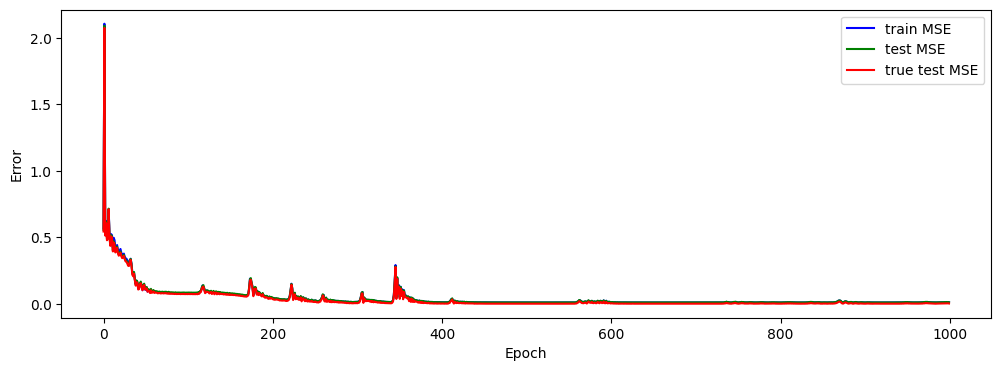

test mse : 0.009342508390545845, denoised test mse : 0.002312917960807681


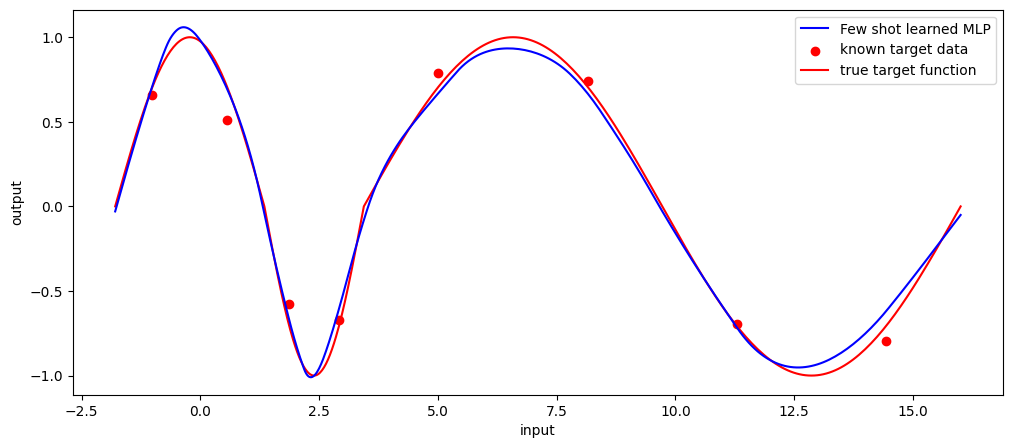

In [174]:
few_shot_learned_mlp_model = MLP()
mlp_optimizer = optim.Adam(few_shot_learned_mlp_model.parameters(), lr=0.1)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
sample_num = random.sample(range(len(x_t)), len(x_t)//5*4)
val_num = list(set(list(range(len(x_t))))-set(sample_num))
best_loss = 10000
best_few_shot_learned_mlp_model = None

for i in tqdm(range(1000)):
    model_list.append(copy.deepcopy(few_shot_learned_mlp_model))
    few_shot_learned_mlp_model.eval()
    test_loss_list.append(torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t_true).detach().item())

    few_shot_learned_mlp_model.train()
    mlp_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t[sample_num]), y_t[sample_num])
    # train_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t)
    
    train_loss.backward()
    mlp_optimizer.step()
    train_loss_list.append(train_loss.detach().item())
    val_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t[val_num]), y_t[val_num])
    if best_loss > val_loss:
        best_few_shot_learned_mlp_model = copy.deepcopy(few_shot_learned_mlp_model)
        best_loss = val_loss

plt.figure(figsize=(12,4))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), test_loss_list, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.plot(x_t, best_few_shot_learned_mlp_model(x_t).detach().numpy(), c='blue', label='Few shot learned MLP', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {torch.nn.functional.mse_loss(best_few_shot_learned_mlp_model(x_t[val_num]), y_t[val_num])}, denoised test mse : {torch.nn.functional.mse_loss(best_few_shot_learned_mlp_model(x_t[val_num]), y_t_true[val_num])}")